## Quora Insincere Questions Classification Kaggle Challenge

In [5]:
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
import os
import time
import re
import string
import unicodedata
import pandas as pd
import numpy as np
from scipy import sparse
from contextlib import contextmanager
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression


In [8]:

import os
import string
import pickle
import random

In [9]:
# Loading the Train and Test Sets

train = pd.read_csv('train.csv.zip')
test  = pd.read_csv('test.csv.zip')
full_data = [train, test]
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
None


In [6]:
train.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [10]:
train.shape

(1306122, 3)

In [11]:
train_target = train['target'].values

np.unique(train_target)

array([0, 1])

### Distribution of the Target Class

In [12]:
sincere_q = (train['target'] == 0).sum()
insincere_q = (train['target'] == 1).sum()

sincere_q, insincere_q

(1225312, 80810)

Text(0,0.5,'Frequency')

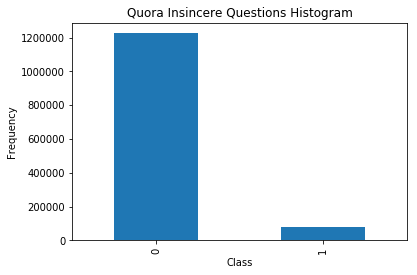

In [13]:
count_classes = pd.value_counts(train['target'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Quora Insincere Questions Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [17]:
rate_sincere_q = (sincere_q/len(train['target']))*100
rate_insincere_q = (insincere_q/len(train['target']))*100
rate_sincere_q, rate_insincere_q
print( '{}% of questions are sincere and {}% are insincere'.format(rate_sincere_q, rate_insincere_q))

0% of questions are sincere and 0% are insincere




### Balancing the Imbalanced Dataset

In [18]:
import random

## Features Scaling

In [19]:
index_insincere_q = np.array(train[train['target'] == 1].index) # len = 80810 
index_sincere_q = np.array(train[train['target'] == 0].index)
index_sincere_q_reduc = random.sample(list(index_sincere_q), int(1.8*len(index_insincere_q)))

In [21]:
X = pd.concat([train['question_text'][index_insincere_q], train['question_text'][index_sincere_q_reduc]])
y = pd.concat([train['target'][index_insincere_q], train['target'][index_sincere_q_reduc]])
#X = df['question_text']
#y = df['target']
X.shape, y.shape

((226268,), (226268,))

The proportion of insincere questions and sincere questions is the same

## Feature Engineering in Text

For EDA and later modeling, it might be a good idea to create some metafeatures. This work is partly based on SRK's great EDAs, and this one in particular. The metafeatures that we'll create are:

Number of words in the text

Number of unique words in the text

Number of characters in the text

Number of stopwords

Number of punctuations

Number of upper case words

Number of title case words

Average length of the words

In [23]:
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
eng_stopwords = set(stopwords.words("english"))

In [25]:
## Number of words in the text ##
train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
train.head(3)

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,9,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,2,0,2,5.800000


In [28]:
sincere_questions = train[train['target'] == 0]
insincere_questions = train[train['target'] == 1]
insincere_questions.tail(5)

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
1306093,fffeba722d9b371bd1b9,How is it to have intimate relation with your ...,1,10,10,53,7,1,0,1,4.400000
1306094,fffee269360dd0d3947a,Why is it when singers have lyrics about voice...,1,35,33,205,17,3,0,2,4.885714
1306099,ffff0e4ea1bb6e16feec,Do pakis smell of curry and shit?,1,7,7,33,3,1,0,1,3.857143
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1,35,34,213,15,7,1,9,5.114286
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1,7,7,35,5,1,0,2,4.142857


### Generating Count Based And Demographical Features

In [30]:
from tqdm import tqdm # I love this handy tool! 
print(">> Generating Count Based And Demographical Features")
for df in ([train]):
    df['length'] = df['question_text'].apply(lambda x : len(x))
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    df['num_exclamation_marks'] = df['question_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['question_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['question_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['num_sad'] = df['question_text'].apply(lambda comment: sum(comment.count(w) for w in (':-<', ':()', ';-()', ';(')))

>> Generating Count Based And Demographical Features


Let's have a glance at new features ...

In [31]:
train[train.columns[2:]].head(8)

,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,words_vs_unique,num_smilies,num_sad
0,0,13,13,72,7,1,0,2,4.615385,72,2,0.027778,0,1,0,0,1.000000,0,0
1,0,16,15,81,9,2,0,1,4.125000,81,1,0.012346,0,1,1,0,0.937500,0,0
2,0,10,8,67,3,2,0,2,5.800000,67,2,0.029851,0,2,0,0,0.800000,0,0
3,0,9,9,57,3,1,0,4,5.444444,57,4,0.070175,0,1,0,0,1.000000,0,0
4,0,15,15,77,8,1,2,3,4.200000,77,3,0.038961,0,1,0,0,1.000000,0,0
5,0,10,10,72,3,2,0,6,6.300000,72,6,0.083333,0,1,1,0,1.000000,0,0
6,0,18,17,113,10,2,0,2,5.333333,113,2,0.017699,0,1,1,0,0.944444,0,0
7,0,14,14,69,7,2,1,3,4.000000,69,3,0.043478,0,1,1,0,1.000000,0,0


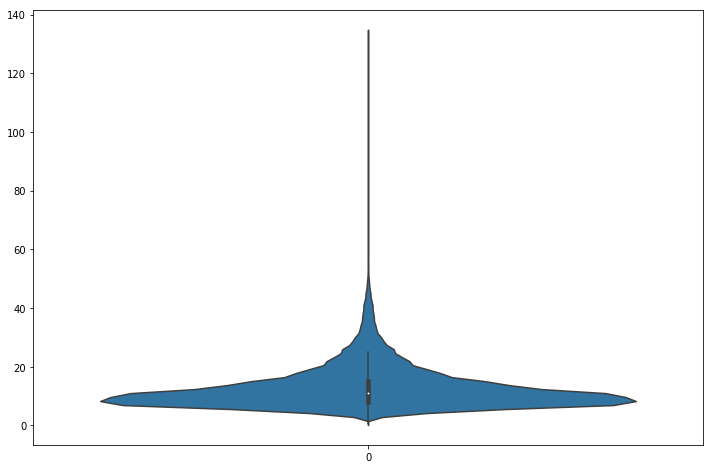

In [13]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words'])
plt.show()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [32]:
vct = CountVectorizer(stop_words='english', ngram_range=(2, 3), lowercase=False)
svd = TruncatedSVD(n_components=100, random_state=42)
tfvec = TfidfVectorizer(stop_words='english', lowercase=False)

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(18, 30))
for i, ax in enumerate(axes.flat):
    components.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)


In [14]:
eng_features = ['num_words', 'num_unique_words', 'num_chars', 
                'num_stopwords', 'num_punctuations', 'num_words_upper', 
                'num_words_title', 'mean_word_len']

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred = 0
oof_pred = np.zeros([train.shape[0],])

x_test = test[eng_features].values
for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train.loc[train_index][eng_features].values, train.loc[val_index][eng_features].values
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(C= 0.1)
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(x_test)[:,1]
    test_pred += 0.2*preds
    oof_pred[val_index] = val_preds

5it [00:48,  9.79s/it]


In [16]:
pred_train = (oof_pred > 0.5).astype(np.int)
f1_score(train_target, pred_train)

0.043989167549746855

In [17]:
f1_score(train_target, pred_train)

0.043989167549746855

In [18]:
pred_train = (oof_pred > 0.12).astype(np.int)
f1_score(train_target, pred_train)

0.25614514752020445

In [19]:
train_text = train['question_text']
test_text = test['question_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_tf = 0
oof_pred_tf = np.zeros([train.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(test_word_features)[:,1]
    test_pred_tf += 0.2*preds
    oof_pred_tf[val_index] = val_preds

5it [01:58, 23.78s/it]


### Split datas in train and test set

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((181014,), (181014,), (45254,), (45254,))

### Preprocessing with NTLK

In [34]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

#### Tokenizing

Creation of a tokenize's function permitting to automatically tokenize our train and test set

In [36]:
def tokenize(data):
    tokenized_docs = [word_tokenize(doc.lower()) for doc in data]
    alpha_tokens = [[t for t in doc if t.isalpha() == True] for doc in tokenized_docs]
    stemmer = PorterStemmer ()
    stemmed_tokens = [[stemmer.stem(alpha) for alpha in doc] for doc in alpha_tokens]
    X_stem_as_string = [" ".join(x_t) for x_t in stemmed_tokens]
    return X_stem_as_string

In [38]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Preprocessing pipeline

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [42]:
vct = CountVectorizer(stop_words='english', ngram_range=(2, 3), lowercase=False)
svd = TruncatedSVD(n_components=100, random_state=42)
tfvec = TfidfVectorizer(stop_words='english', lowercase=False)

In [43]:
preprocessing_pipe = Pipeline([
    ('vectorizer', tfvec),
    ('svd', svd),
])

In [45]:
lsa_train = preprocessing_pipe.fit_transform(X_train)
lsa_train.shape

(181014, 100)

### Visualizing the most informative features

In [49]:
components = pd.DataFrame(data=svd.components_, columns=preprocessing_pipe.named_steps['vectorizer'].get_feature_names())
components.head(3)

,00,000,0000,000000000001,0000001,000000199,000009808,000009820,000009920,0000218,...,红宝书,送客,都市,阻天下悠悠之口,鰹節,麻辣乾鍋,같이,이와,천사,포경수술
0,0.000638,0.004228,0.000023,0.000014,0.000036,0.000004,0.000009,0.000009,0.000004,3.930406e-05,...,0.000019,1.258328e-05,0.000017,0.000013,1.417516e-05,0.000010,0.000053,0.000053,0.000021,0.000016
1,0.000310,0.001221,0.000002,-0.000012,-0.000029,-0.000005,-0.000010,-0.000010,-0.000005,-8.815337e-07,...,0.000045,-4.886860e-07,-0.000003,0.000003,-1.963727e-06,0.000018,0.000078,0.000078,-0.000003,-0.000004
2,0.000308,0.002386,0.000082,-0.000008,-0.000014,-0.000003,-0.000006,-0.000006,-0.000003,1.793985e-04,...,-0.000013,-4.232630e-06,0.000002,-0.000002,-1.698525e-07,-0.000002,-0.000009,-0.000009,-0.000003,0.000002


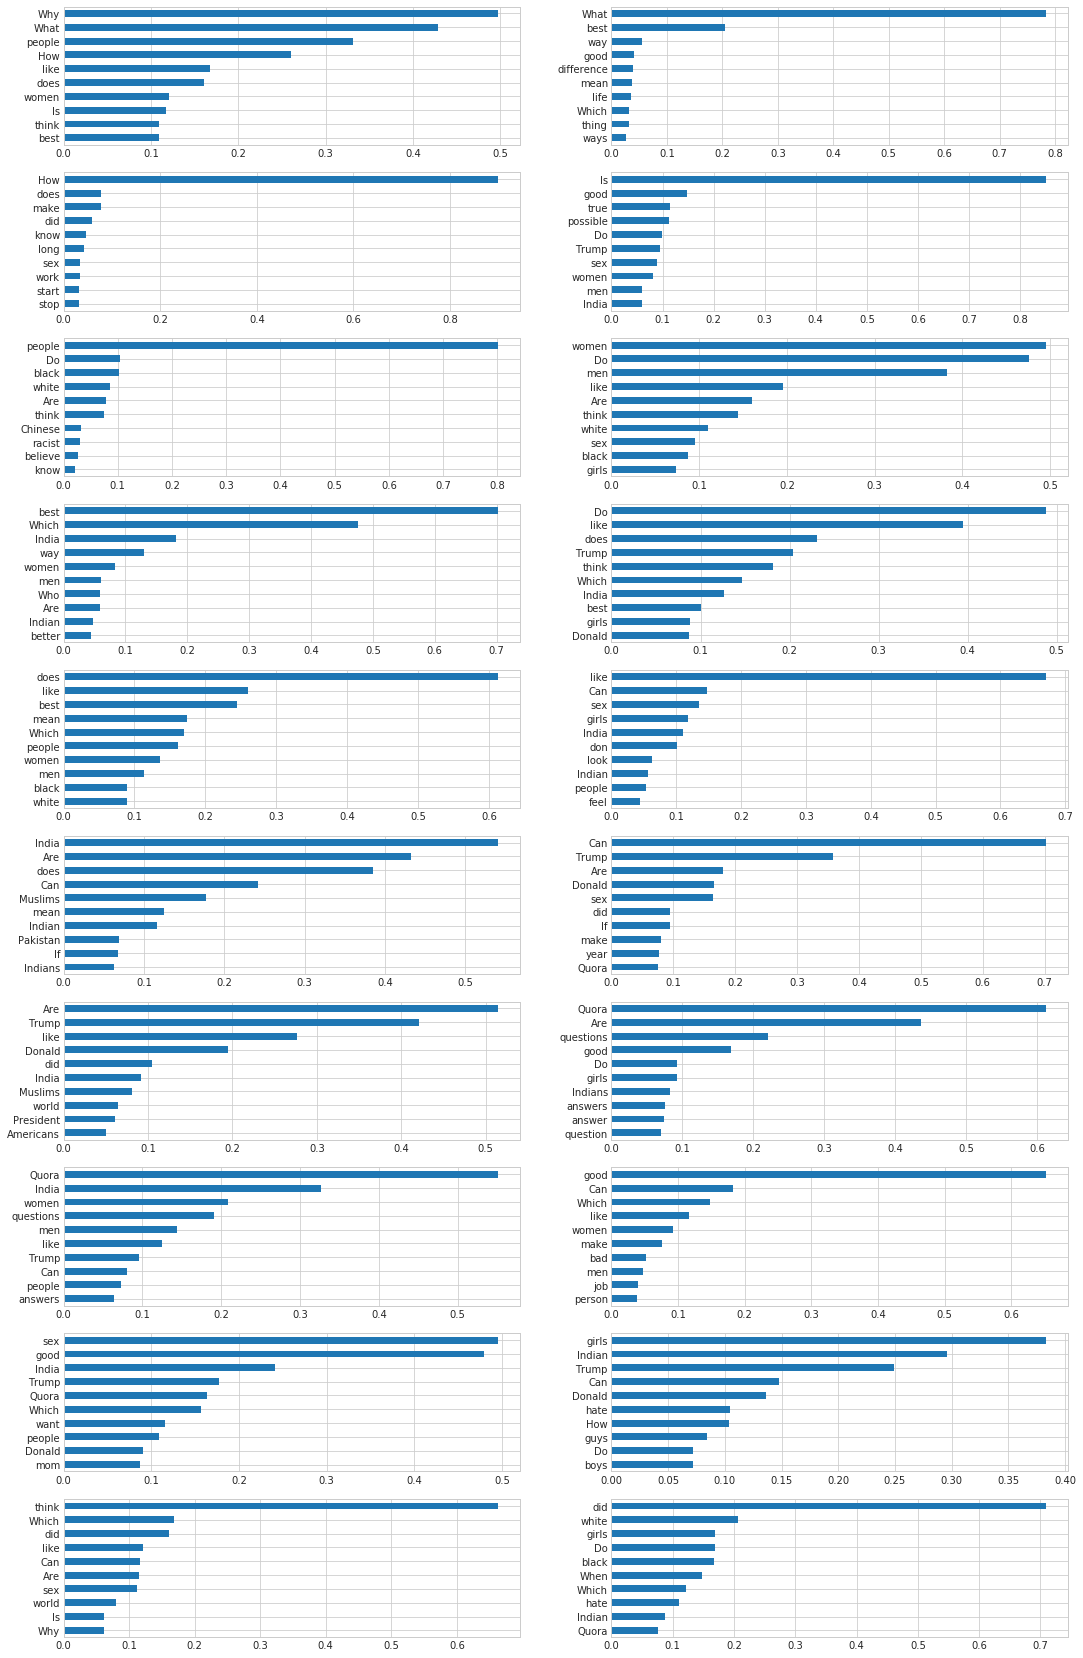

In [47]:
fig, axes = plt.subplots(10, 2, figsize=(18, 30))
for i, ax in enumerate(axes.flat):
    components.iloc[i].sort_values(ascending=False)[:10].sort_values().plot.barh(ax=ax)

## MACHINE LEARNING MODELS
### Creation of a pipeline with prepocessing pipeline

In [52]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

In [53]:
rf = RandomForestClassifier (class_weight='balanced_subsample')
xgbc = xgb.XGBClassifier() 
mb = MultinomialNB()
pipe = Pipeline([
    ('vectorizer', tfvec),
    ('mb', mb)
])

In [57]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)

### Confusion Matrix

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

In [59]:
cm = confusion_matrix(y_valid, y_pred)
cm

array([[26205,  2887],
       [ 3045, 13117]])

In [60]:
labels = ['sincere', 'unsincere']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)
df_cm

,sincere,unsincere
sincere,26205,2887
unsincere,3045,13117


### VALIDATION

In [61]:
from sklearn.model_selection import cross_val_score

In [63]:
score = cross_val_score(pipe, X_valid, y=y_valid, cv=5, scoring='f1_macro')
score

array([0.84675143, 0.85040385, 0.84668843, 0.846584  , 0.84791018])

In [64]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     29092
           1       0.82      0.81      0.82     16162

   micro avg       0.87      0.87      0.87     45254
   macro avg       0.86      0.86      0.86     45254
weighted avg       0.87      0.87      0.87     45254



In [ ]:
y_test_true = pipe.predict(X_test)